# Μηχανική Μάθηση - Εργασία 1 - Μέρος Β: Μη Επιβλεπόμενη Μάθηση

Στο δεύτερο μέρος της ατομικής αυτής εργασίας στοχεύουμε στην επίτευξη συσταδοποίησης των δεδομένων δύο ξεχωριστών συνόλων, μέσω εφαρμογής μεθόδων μη επιβλεπόμενης μάθησης.

Το πρώτο σύνολο δεδομένων («μικρό») ανακτάται από τη βάση δεδομένων `fcps` (Fundamental Clustering Problem Suite) και ονομάζεται EngyTime, ενώ το δεύτερο σύνολο («μεγάλο») αποτελεί μια τροποποιημένη εκδοχή των συνόλων τύπου G2 από το `SIPU` (Speech and Image Processing Unit, School of Computing, University of Eastern Finland) και ονομάζεται g2mg_128_70. Οι χαρακτηρισμοί «μικρό» και «μεγάλο» αποδίδονται στα σύνολα βάσει των διαστάσεων κάθε δεδομένου, οι οποίες θα αναλυθούν στο ακόλουθο μέρος της εργασίας.

Και στις δύο περιπτώσεις, τα δεδομένα σχηματίζουν 2 συστάδες (clusters), μια πληροφορία την οποία τυπικά δεν είμαστε σε θέση να διαθέτουμε υπό ρεαλιστικές συνθήκες, όμως εδώ (κατόπιν υπόδειξης της εκφώνησης) θα την αξιοποιήσουμε όταν αυτό καταστεί απαραίτητο, όπως για παράδειγμα στην αρχικοποίηση των αλγορίθμων.

Πριν ξεκινήσουμε με την επισκόπηση των συνόλων δεδομένων, θα κάνουμε `import` ορισμένες βασικές βιβλιοθήκες και θα ορίσουμε κάποια πράγματα απαραίτητα για το formatting της εργασίας (auxiliary functions).

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import time

%matplotlib inline

# to ignore warnings
import warnings 
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import colors

# Some custom colors
mycol = (0.13333, 0.35294, 0.38824)
mycomplcol = (0.6, 0.4549, 0.2078)

sns.set(style = "darkgrid") # for graphs style

# to present plt.show() graphs centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Επισκόπηση


Το πρώτο βήμα της επεξεργασίας αποτελεί η λήψη των δεδομένων, τα οποία σε κάθε περίπτωση αποτελούνται από ένα αρχείο με χαρακτηριστικά, καθώς και ένα αρχείο με ένα δείκτη (label) που υποδεικνύει σε ποιο cluster ανήκει το κάθε δεδομένο. Σημειώνουμε εδώ πως και στις δύο περιπτώσεις παρέχεται ένα επιπλέον αρχείο με εναλλακτικά labels (labels1), το οποίο όμως κατόπιν διευκρίνησης από τον κ. Σιόλα θα αγνοηθεί, καθώς αποτελεί θόρυβο. Η λήψη των δεδομένων γίνεται μέσω των ακόλουθων εντολών. 

In [3]:
# Parent link
github = "https://github.com/gagolews/clustering_benchmarks_v1/raw/master/"

# 2D Dataset
fcps = "fcps/engytime"
fcps_url = github + fcps + ".data.gz"
fcps_labels_0 = github + fcps + ".labels0.gz"

!wget -q $fcps_url # -q is added so that the notebook doesn't spam wget's output. If required, remove it for debugging reasons
!wget -q $fcps_labels_0

X_small = np.loadtxt(fcps.split("/")[1]+".data.gz", ndmin=2)
y_small = np.loadtxt(fcps.split("/")[1]+".labels0.gz", dtype=np.intc)-1 # -1 is inserted so that we can have 0-1 labels and not 1-2 labels

# 128D Dataset
g2mg = "g2mg/g2mg_128_70"
g2mg_url = github + g2mg + ".data.gz"
g2mg_labels_0 = github + g2mg + ".labels0.gz"

!wget -q $g2mg_url
!wget -q $g2mg_labels_0

X_big = np.loadtxt(g2mg.split("/")[1]+".data.gz", ndmin=2)
y_big = np.loadtxt(g2mg.split("/")[1]+".labels0.gz", dtype=np.intc)-1

In [4]:
print(f"▶ The «small» dataset contains {X_small.shape[0]} entries, each having {X_small.shape[1]} feature(s).")
print(f"▶ These entries are known to have come from {len(np.unique(y_small))} cluster(s).")
print(f"▶ The «big» dataset contains {X_big.shape[0]} entries, each having {X_big.shape[1]} feature(s).")
print(f"▶ These entries are known to have come from {len(np.unique(y_big))} cluster(s).")

▶ The «small» dataset contains 4096 entries, each having 2 feature(s).
▶ These entries are known to have come from 2 cluster(s).
▶ The «big» dataset contains 2048 entries, each having 128 feature(s).
▶ These entries are known to have come from 2 cluster(s).


Βάσει των παραπάνω, βλέπουμε πως κάθε dataset περιλαμβάνει δεδομένα που έχουν προκύψει από 2 clusters, επομένως η πληροφορία αυτή θα χρησιμοποιηθεί στην αρχικοποίηση του εκάστοτε αλγορίθμου συσταδοποίησης. Η ανάλυση κάθε συνόλου θα πραγματοποιηθεί στις επόμενες δύο ενότητες, ξεχωριστά για καθένα από αυτά.

## 2D Σύνολο Δεδομένων (EngyTime)

Ως πρώτο βήμα της ανάλυσης του συνόλου EngyTime, θα περάσουμε τα δεδομένα σε ένα pandas dataframe για διευκόλυνση στους διάφορους χειρισμούς και στη συνέχεια θα τα οπτικοποιήσουμε σε ένα διάγραμμα διασποράς, ώστε να έχουμε μια εικόνα του συνόλου μας.

In [5]:
# Casting the numpy array into a pandas dataframe for easier manipulations
df = pd.DataFrame(X_small)

# Setting some basic header names
column_dict = {}
for i in range(X_small.shape[1]):
    column_dict[i] = 'Feature '+str(i+1)

df = df.rename(columns=column_dict)
df['Actual Cluster Binary'] = y_small

# Some refinements for aesthetic reasons
df.loc[(df['Actual Cluster Binary']==0), 'Actual Cluster'] = 'Cluster #1'
df['Actual Cluster'] = df['Actual Cluster'].fillna('Cluster #2')

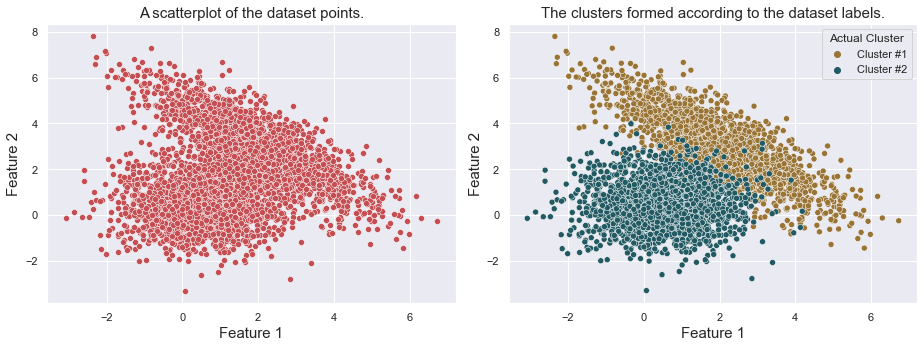

In [6]:
palette = {'Cluster #1' : mycomplcol, 'Cluster #2' : mycol}

fig, [ax1,ax2] = plt.subplots(1,2, figsize=(13,5))

sns.scatterplot(ax=ax1, x='Feature 1', y='Feature 2', data=df, color='r', alpha=1.0)
ax1.set_title("A scatterplot of the dataset points.",fontsize=15)
ax1.set_xlabel("Feature 1", fontsize=15)
ax1.set_ylabel("Feature 2", fontsize=15)

sns.scatterplot(ax=ax2, x='Feature 1', y='Feature 2', data=df, hue='Actual Cluster', palette=palette, alpha=1.0)
ax2.set_title("The clusters formed according to the dataset labels.",fontsize=15)
ax2.set_xlabel("Feature 1", fontsize=15)
ax2.set_ylabel("Feature 2", fontsize=15)

plt.tight_layout()
plt.show()

Ούτως ή άλλως, θεωρούμε γνωστό το πλήθος των clusters στα οποία αντιστοιχούν τα σημεία του συνόλου μας, επομένως παραθέσαμε παραπάνω και την πραγματική εικόνα βάσει των δοσμένων labels, προκειμένου να έχουμε υπ' όψιν τι αναμένουμε να δούμε ως επιτυχή συσταδοποίηση της εκάστοτε μεθόδου. Σε πρώτη φάση, πάντως, είναι φανερό πως τα σημεία έχουν προκύψει από ένα μίγμα Γκαουσιανών κατανομών, επομένως αναμένουμε η συσταδοποίηση μέσω GMM να δώσει καλά αποτελέσματα.

### Αλγόριθμος k-Means

Η πρώτη απόπειρα συσταδοποίησης θα πραγματοποιηθεί μέσω του αλγορίθμου k-Means, και συγκεκριμένα την υλοποίηση της `sklearn`.

In [7]:
# import kmeans
from sklearn.cluster import KMeans

# apply kmeans for 2 clusters, as indicated by len(np.unique(y_small))
kmeans = KMeans(n_clusters=2, random_state=24).fit(X_small)

preds_kmeans = (kmeans.labels_+1)%2 # this is done because kmeans returns reverse labels

# append the calculations to the helper dataframe
df['KMeans Binary'] = preds_kmeans

# the refinement
df.loc[(df['KMeans Binary']==0), 'KMeans Cluster'] = 'Cluster #1'
df['KMeans Cluster'] = df['KMeans Cluster'].fillna('Cluster #2')

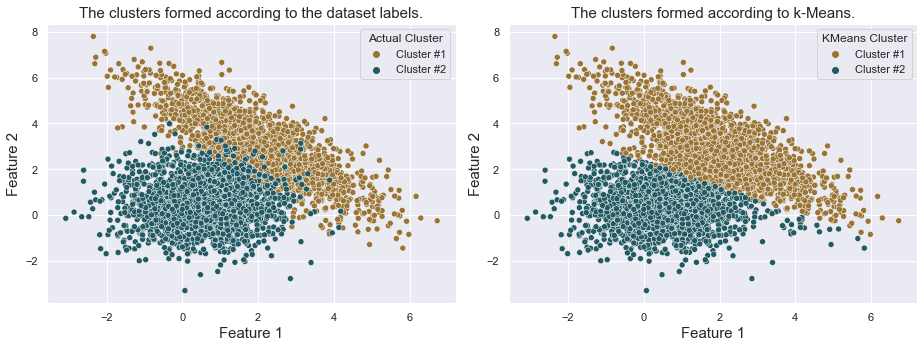

In [8]:
# Define a function to compare clustering
def ClustCompare(df,actual,predicted,method):
    
    palette = {'Cluster #1' : mycomplcol, 'Cluster #2' : mycol}

    fig, [ax1,ax2] = plt.subplots(1,2, figsize=(13,5))

    sns.scatterplot(ax=ax1, x='Feature 1', y='Feature 2', data=df, hue=actual, palette=palette, alpha=1.0)
    ax1.set_title("The clusters formed according to the dataset labels.",fontsize=15)
    ax1.set_xlabel("Feature 1", fontsize=15)
    ax1.set_ylabel("Feature 2", fontsize=15)

    sns.scatterplot(ax=ax2, x='Feature 1', y='Feature 2', data=df, hue=predicted, palette=palette, alpha=1.0)
    ax2.set_title(f"The clusters formed according to {method}.",fontsize=15)
    ax2.set_xlabel("Feature 1", fontsize=15)
    ax2.set_ylabel("Feature 2", fontsize=15)

    plt.tight_layout()
    plt.show()
    
    return

# Plot the two clusters
ClustCompare(df,'Actual Cluster','KMeans Cluster','k-Means')

Έχοντας ως αναφορά την αναμενόμενη εικόνα, βλέπουμε ότι ο αλγόριθμος kMeans οδηγεί σε clustering το οποίο, οπτικά τουλάχιστον, δε φαίνεται να είναι πολύ κακό δεδομένης της απλοϊκότητάς του. Φυσικά, αυτό θα κριθεί ορθότερα όχι με ανθρώπινους όρους, αλλά βάσει συγκεκριμένων μετρικών.

Για την αξιολόγηση της παραπάνω συσταδοποίησης (καθώς και όλων των ακόλουθων), έχοντας ως αναφορά τα δοσμένα labels, θα αξιοποιηθούν οι μετρικές `Adjusted Rand Index`, `Adjusted Mutual Information` και `V-measure`.

In [9]:
# a mini function for rounding
def CustRound(x):
    return round(100*x,2)

# What about a simple "accuracy" test?
print(f"A foolish attempt would be to evaluate the clustering using something similar to the classification accuracy.")
print(f"In this case, the score would be {CustRound(((y_small-preds_kmeans)==0).sum()/len(y_small))}%!")

A foolish attempt would be to evaluate the clustering using something similar to the classification accuracy.
In this case, the score would be 95.14%!


In [10]:
# import the library for the metrics
from sklearn import metrics

# Initialize some lists to store the scores
adj_rand_inds = []
adj_mut_info = []
v_meas = []

adj_rand = CustRound(metrics.adjusted_rand_score(y_small, preds_kmeans))
adj_mut = CustRound(metrics.adjusted_mutual_info_score(y_small, preds_kmeans))
v = CustRound(metrics.v_measure_score(y_small, preds_kmeans))

print(f"The Adjusted Rand Index score for the k-Means clustering is {adj_rand}%.")
print(f"The Adjusted Mutual Information score for the k-Means clustering is {adj_mut}%.")
print(f"The V-Measure score for the k-Means clustering is {v}%.")

adj_rand_inds.append(adj_rand)
adj_mut_info.append(adj_mut)
v_meas.append(v)

The Adjusted Rand Index score for the k-Means clustering is 81.51%.
The Adjusted Mutual Information score for the k-Means clustering is 72.96%.
The V-Measure score for the k-Means clustering is 72.96%.


Βλέπουμε πως, εάν κανείς προσπαθούσε να αξιολογήσει τη συσταδοποίηση που πραγματοποίησε ο k-Means με πιο απλοϊκές μεθόδους, όπως για παράδειγμα υπολογίζοντας την «ορθότητα» κατ' αντιστοιχία με ένα πρόβλημα ταξινόμησης, θα υπολόγιζε πολύ υψηλότερα στατιστικά από τα παραπάνω, χωρίς όμως αυτά να ανταποκρίνονται στην πραγματικότητα. Χρησιμοποιώντας τις κατάλληλες μετρικές, η απόδοση του k-Means αξιολογείται πιο στοχευμένα και, παρότι προκύπτει σχετικά υψηλή, δεδομένης πάντα της απλοϊκότητας του αλγορίθμου, φαίνεται ξεκάθαρα πως απέχει σημαντικά από την απλοϊκή προσέγγιση της ορθότητας.

Ένα χαρακτηριστικό που διαθέτει καθεμία εκ των άνω μετρικών, το οποίο τις καθιστά κατάλληλες για την παρούσα αξιολόγηση, είναι πως βασίζονται στο πραγματικό labeling των δεδομένων προκειμένου να αξιολογήσουν την απόδοση της συσταδοποίησης. Συνήθως, βέβαια, αυτό αποτελεί το βασικότερό τους μειονέκτημα, αφού σε ρεαλιστικά προβλήματα δε γνωρίζουμε εκ των προτέρων τα πραγματικά labels των δεδομένων.

Για καθεμιά εξ αυτών των μετρικών θα κατασκευάσουμε έναν markdown πίνακα, προκειμένου να παραθέτουμε τις αντίστοιχες τιμές τους για κάθε αλγόριθμο συσταδοποίησης, τον οποίο θα ανανεώνουμε καθώς δοκιμάζουμε νέους αλγορίθμους. Τα καλύτερα αποτελέσματα κάθε κατηγορίας θα σημειώνονται σε κάθε περίπτωση με πράσινο χρώμα.

| | k-Means |
| :-: | :-: |
| **Adjusted Rand Index** | <font color='green'>81.51%</font> |
| **Adjusted Mutual Information** | <font color='green'>72.96%</font> |
| **V-Measure** | <font color='green'>72.96%</font> |

### Αλγόριθμος HAC

Με αντίστοιχο τρόπο προχωρούμε και στην υλοποίηση των υπόλοιπων αλγορίθμων, εφαρμόζοντας αυτή τη φορά HAC (Hierarchical Agglomerative Clustering), σε υλοποίηση της `fastcluster`.

In [11]:
# import the required libraries and methods
import fastcluster
from scipy.cluster.hierarchy import fcluster

# Compute linkage matrix
Z1 = fastcluster.single(X_small)
# Find the cluster labels
preds_single = fcluster(Z1, 2, criterion='maxclust')%2 # the mod2 is inserted to ensure that we have the same labels

# Compute linkage matrix
Z2 = fastcluster.average(X_small)
# Find the cluster labels
preds_avg = fcluster(Z2, 2, criterion='maxclust')%2 # the mod2 is inserted to ensure that we have the same labels

# Compute linkage matrix
Z3 = fastcluster.complete(X_small)
# Find the cluster labels
preds_cmpl = fcluster(Z3, 2, criterion='maxclust')%2 # the mod2 is inserted to ensure that we have the same labels

# Compute linkage matrix
Z4 = fastcluster.ward(X_small)
# Find the cluster labels
preds_ward = fcluster(Z4, 2, criterion='maxclust')%2 # the mod2 is inserted to ensure that we have the same labels

In [12]:
# Update the dataframe

df['HAC Single Binary'] = preds_single
df.loc[(df['HAC Single Binary']==0), 'HAC Single'] = 'Cluster #1'
df['HAC Single'] = df['HAC Single'].fillna('Cluster #2')

df['HAC Average Binary'] = preds_avg
df.loc[(df['HAC Average Binary']==0), 'HAC Average'] = 'Cluster #1'
df['HAC Average'] = df['HAC Average'].fillna('Cluster #2')

df['HAC Complete Binary'] = preds_cmpl
df.loc[(df['HAC Complete Binary']==0), 'HAC Complete'] = 'Cluster #1'
df['HAC Complete'] = df['HAC Complete'].fillna('Cluster #2')

df['HAC Ward Binary'] = preds_ward
df.loc[(df['HAC Ward Binary']==0), 'HAC Ward'] = 'Cluster #1'
df['HAC Ward'] = df['HAC Ward'].fillna('Cluster #2')

Παραθέτουμε, για ακόμη μια φορά, την εικόνα που λαμβάνουμε με βάση τα αληθή labels, προκειμένου να μπορέσουμε στη συνέχεια να τη συγκρίνουμε με τα αποτελέσματα των HAC κάθε τύπου.

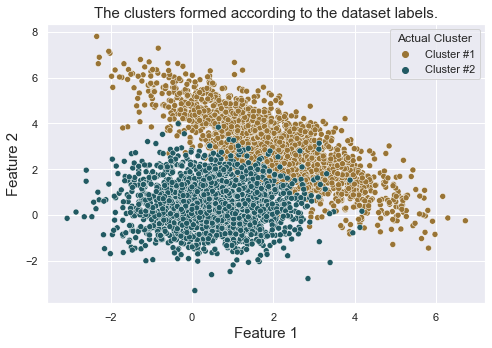

In [13]:
# Some manual plotting
palette = {'Cluster #1' : mycomplcol, 'Cluster #2' : mycol}

fig, ax = plt.subplots(1,1, figsize=(7,5))

sns.scatterplot(ax=ax, x='Feature 1', y='Feature 2', data=df, hue='Actual Cluster', palette=palette, alpha=1.0)
ax.set_title("The clusters formed according to the dataset labels.",fontsize=15)
ax.set_xlabel("Feature 1", fontsize=15)
ax.set_ylabel("Feature 2", fontsize=15)

plt.tight_layout()
plt.show()

Τα αποτελέσματα που λαμβάνουμε μέσω των HAC μεθόδων απεικονίζονται παρακάτω.

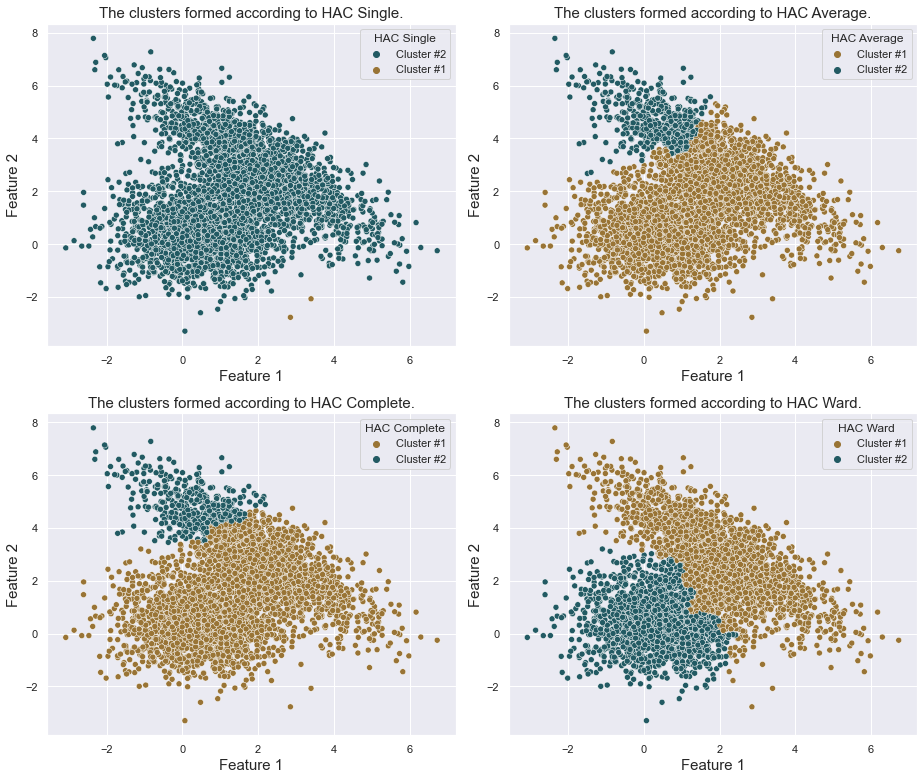

In [14]:
# Plotting the four HAC results

fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize=(13,11))

for ax, hactype in zip([ax1,ax2,ax3,ax4],['Single','Average','Complete','Ward']):
    sns.scatterplot(ax=ax, x='Feature 1', y='Feature 2', data=df, hue='HAC '+hactype, palette=palette, alpha=1.0)
    ax.set_title(f"The clusters formed according to HAC {hactype}.",fontsize=15)
    ax.set_xlabel("Feature 1", fontsize=15)
    ax.set_ylabel("Feature 2", fontsize=15)

plt.tight_layout()
plt.show()

Οπτικά, καθίσταται εμφανές πως η συσταδοποίηση μέσω HAC δεν αποφέρει ικανοποιητικά αποτελέσματα. Παρ' όλα αυτά, προχωράμε στον υπολογισμό των αντίστοιχων μετρικών, προκειμένου να επαληθεύσουμε την υποψία αυτή.

In [15]:
for hacpreds, hactype in zip([preds_single,preds_avg,preds_cmpl,preds_ward],['Single','Average','Complete','Ward']):

    adj_rand = CustRound(metrics.adjusted_rand_score(y_small, hacpreds))
    adj_mut = CustRound(metrics.adjusted_mutual_info_score(y_small, hacpreds))
    v = CustRound(metrics.v_measure_score(y_small, hacpreds))

    print(f"The Adjusted Rand Index score for the HAC {hactype} is {adj_rand}%.")
    print(f"The Adjusted Mutual Information score for the HAC {hactype} is {adj_mut}%.")
    print(f"The V-Measure score for the HAC {hactype} is {v}%.")
    print(101*'-')

    adj_rand_inds.append(adj_rand)
    adj_mut_info.append(adj_mut)
    v_meas.append(v)

The Adjusted Rand Index score for the HAC Single is 0.0%.
The Adjusted Mutual Information score for the HAC Single is 0.05%.
The V-Measure score for the HAC Single is 0.1%.
-----------------------------------------------------------------------------------------------------
The Adjusted Rand Index score for the HAC Average is 5.1%.
The Adjusted Mutual Information score for the HAC Average is 14.85%.
The V-Measure score for the HAC Average is 14.87%.
-----------------------------------------------------------------------------------------------------
The Adjusted Rand Index score for the HAC Complete is 4.06%.
The Adjusted Mutual Information score for the HAC Complete is 13.92%.
The V-Measure score for the HAC Complete is 13.94%.
-----------------------------------------------------------------------------------------------------
The Adjusted Rand Index score for the HAC Ward is 71.85%.
The Adjusted Mutual Information score for the HAC Ward is 64.69%.
The V-Measure score for the HAC War

Πράγματι, και οι σχετικές μετρικές επαληθεύουν το συμπέρασμα που εξήχθη οπτικά: ο HAC δεν είναι κατάλληλος για τη συσταδοποίηση των συγκεκριμένων δεδομένων, με μοναδική ίσως εξαίρεση τον HAC με σύνδεσμο `Ward`, ο οποίος είναι ο μόνος που επιστρέφει ένα σχετικά ικανοποιητικό αποτέλεσμα.

Παρακάτω παρατίθεται ο επαυξημένος πίνακας με τις μέχρι τώρα επιδόσεις.

| | k-Means | HAC - Single | HAC - Average | HAC - Complete | HAC - Ward |
| :-: | :-: | :-: | :-: | :-: | :-: |
| **Adjusted Rand Index** | <font color='green'>81.51%</font> | 0.00% | 5.10% | 4.06% | 71.85% |
| **Adjusted Mutual Information** | <font color='green'>72.96%</font> | 0.05% | 14.85% | 13.92% | 64.69% |
| **V-Measure** | <font color='green'>72.96%</font> | 0.10% | 14.87% | 13.94% | 64.70% |

### Αλγόριθμος GMM

Προχωρούμε στον αλγόριθμο που αναμένουμε να έχει και τη βέλτιστη επίδοση, μιας και οπτικά μοιάζει τα δεδομένα του παρόντος συνόλου να έχουν προκύψει από ένα μίγμα δύο Γκαουσιανών κατανομών. Η υλοποίηση που αξιοποιείται είναι αυτή της `sklearn`.

In [16]:
# import gmm
from sklearn.mixture import GaussianMixture

# setup the model
gmm = GaussianMixture(n_components=2, random_state=24)
# predict labels
preds_gmm = (gmm.fit_predict(X_small)+1)%2 # To retain labeling

In [17]:
# Update the dataframe
df['GMM Cluster Binary'] = preds_gmm
df.loc[(df['GMM Cluster Binary']==0), 'GMM Cluster'] = 'Cluster #1'
df['GMM Cluster'] = df['GMM Cluster'].fillna('Cluster #2')

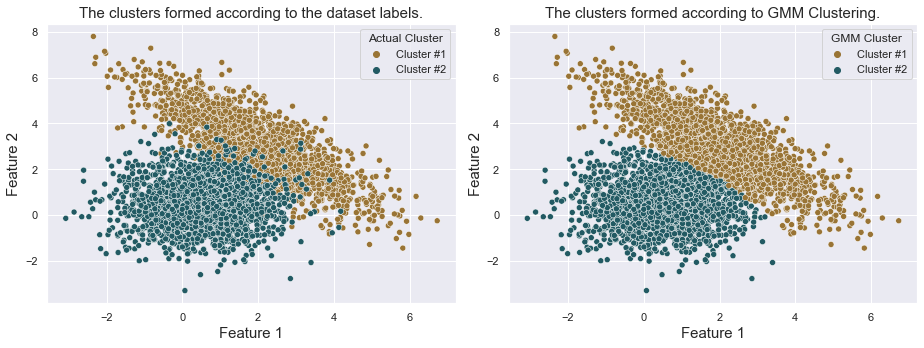

In [18]:
# Plot the two clusters
ClustCompare(df,'Actual Cluster','GMM Cluster','GMM Clustering')

Όπως ήταν αναμενόμενο, τα αποτελέσματα που προκύπτουν μέσω GMM είναι πολύ ικανοποιητικά. Ως προς τις μετρικές, έχουμε:

In [19]:
adj_rand = CustRound(metrics.adjusted_rand_score(y_small, preds_gmm))
adj_mut = CustRound(metrics.adjusted_mutual_info_score(y_small, preds_gmm))
v = CustRound(metrics.v_measure_score(y_small, preds_gmm))

print(f"The Adjusted Rand Index score for the GMM Clustering is {adj_rand}%.")
print(f"The Adjusted Mutual Information score for the GMM Clustering is {adj_mut}%.")
print(f"The V-Measure score for the GMM Clustering is {v}%.")

adj_rand_inds.append(adj_rand)
adj_mut_info.append(adj_mut)
v_meas.append(v)

The Adjusted Rand Index score for the GMM Clustering is 87.16%.
The Adjusted Mutual Information score for the GMM Clustering is 79.02%.
The V-Measure score for the GMM Clustering is 79.03%.


Πράγματι, αυτά είναι τα καλύτερα μέχρι στιγμής αποτελέσματα, ως προς κάθε μετρική. Παρατίθεται παρακάτω ο πίνακας των αποτελεσμάτων ανανεωμένος με τα αποτελέσματα της συσταδοποίησης μέσω GMM.

| | k-Means | HAC - Single | HAC - Average | HAC - Complete | HAC - Ward | GMM |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| **Adjusted Rand Index** | 81.51% | 0.00% | 5.10% | 4.06% | 71.85% | <font color='green'>87.16%</font> |
| **Adjusted Mutual Information** | 72.96% | 0.05% | 14.85% | 13.92% | 64.69% | <font color='green'>79.02%</font> |
| **V-Measure** | 72.96% | 0.10% | 14.87% | 13.94% | 64.70% | <font color='green'>79.03%</font> |

### Αλγόριθμος DBSCAN

Σε πλήρη αντιστοιχία με τα παραπάνω, προχωρούμε στην εφαρμογή του αλγορίθμου DBSCAN σε υλοποίηση της `sklearn`. Η διαφορά εδώ είναι πως η DBSCAN είναι μέθοδος στην οποία ο αριθμός των συστάδων υπολογίζεται αυτόματα, ανάλογα με τις παραμέτρους `eps` και `min_samples`, επομένως δεν έχουμε τη δυνατότητα να αξιοποιήσουμε τη γνώση μας για το πραγματικό πλήθος συστάδων. Φυσικά, υπό ρεαλιστικές συνθήκες το γεγονός αυτό αποτελεί ένα από τα μεγαλύτερα προτερήματα του αλγορίθμου, σε σύγκριση με τους αλγορίθμους που έχουμε δει έως τώρα. Στην προκείμενη όμως φάση και λαμβάνοντας υπ' όψιν πως τα δεδομένα μας είναι πυκνά τοποθετημένα, εικάζουμε πως η DBSCAN δε θα καταφέρει να αναγνωρίσει τις πραγματικές συστάδες.

In [20]:
# import dbscan
from sklearn.cluster import DBSCAN

# in order to use the default DBSCAN parameters, we need to scale our data
from sklearn.preprocessing import StandardScaler

X_small_sc = StandardScaler().fit_transform(X_small)

# perform dbscan using default values
db = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1).fit(X_small)

# predictions
preds_db = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(preds_db)) - (1 if -1 in preds_db else 0)
n_noise_ = list(preds_db).count(-1)

print(f"The number of cluster(s) identified is {n_clusters_}, while {n_noise_} points have been treated as noise.")

The number of cluster(s) identified is 1, while 24 points have been treated as noise.


Πράγματι, ο DBSCAN αποτυγχάνει να διακρίνει μεταξύ των δύο συστάδων. Ο παραπάνω υπολογισμός πραγματοποιήθηκε για τις default τιμές της DBSCAN, παρ' όλα αυτά τα αποτελέσματα γίνονται μόνο χειρότερα με άλλες διαμορφώσεις. Τα αντίστοιχα οπτικά αποτελέσματα απεικονίζονται παρακάτω:

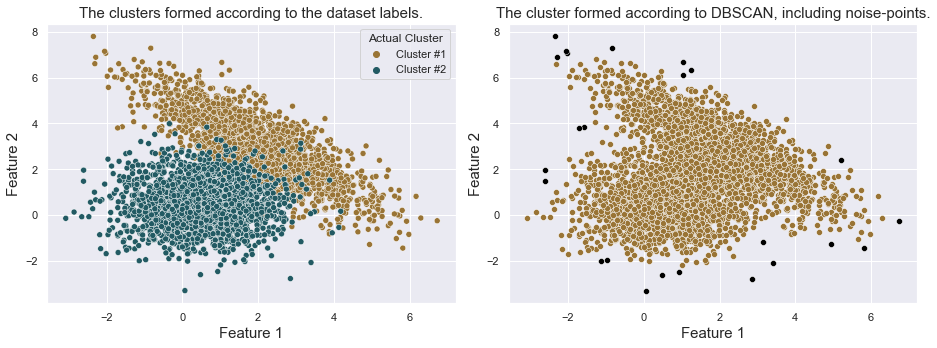

In [21]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(13,5))

sns.scatterplot(ax=ax1, x='Feature 1', y='Feature 2', data=df, hue='Actual Cluster', palette=palette, alpha=1.0)
ax1.set_title("The clusters formed according to the dataset labels.", fontsize=15)
ax1.set_xlabel("Feature 1", fontsize=15)
ax1.set_ylabel("Feature 2", fontsize=15)

# Black removed and is used for noise instead.
for k in set(preds_db):
    if k == -1:
        # Black used for noise.
        col = 'Black'
    else:
        col = mycomplcol

    class_member_mask = preds_db == k

    xy = X_small[class_member_mask]
    ax2.plot(xy[:, 0], xy[:, 1], "o", mfc=col, markeredgecolor="white", markersize=6, mew=0.5, alpha=1.0)

ax2.set_title("The cluster formed according to DBSCAN, including noise-points.", fontsize=15)
ax2.set_xlabel("Feature 1", fontsize=15)
ax2.set_ylabel("Feature 2", fontsize=15)

plt.tight_layout()
plt.show()

Η αποτυχία της DBSCAN είναι εμφανής. Οι σχετικές μετρικές υπολογίζονται ως:

In [22]:
adj_rand = CustRound(metrics.adjusted_rand_score(y_small, preds_db))
adj_mut = CustRound(metrics.adjusted_mutual_info_score(y_small, preds_db))
v = CustRound(metrics.v_measure_score(y_small, preds_db))

print(f"The Adjusted Rand Index score for DBSCAN is {adj_rand}%.")
print(f"The Adjusted Mutual Information score for DBSCAN is {adj_mut}%.")
print(f"The V-Measure score for DBSCAN is {v}%.")

adj_rand_inds.append(adj_rand)
adj_mut_info.append(adj_mut)
v_meas.append(v)

The Adjusted Rand Index score for DBSCAN is -0.0%.
The Adjusted Mutual Information score for DBSCAN is -0.01%.
The V-Measure score for DBSCAN is 0.02%.


Προσθέτοντας τα αποτελέσματα αυτά στον πίνακα των αποτελεσμάτων, προχωρούμε στην επόμενη μέθοδο συσταδοποίησης.

| | k-Means | HAC - Single | HAC - Average | HAC - Complete | HAC - Ward | GMM | DBSCAN |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| **Adjusted Rand Index** | 81.51% | 0.00% | 5.10% | 4.06% | 71.85% | <font color='green'>87.16%</font> | 0.00% |
| **Adjusted Mutual Information** | 72.96% | 0.05% | 14.85% | 13.92% | 64.69% | <font color='green'>79.02%</font> | -0.01% |
| **V-Measure** | 72.96% | 0.10% | 14.87% | 13.94% | 64.70% | <font color='green'>79.03%</font> | 0.02% |

### Αλγόριθμος HDBSCAN

Ο HDBSCAN δεν είναι παρά μια επέκταση του DBSCAN σε μέθοδο ιεραρχικής συσταδοποίησης. Θεωρητικά, θα αναμέναμε στην περίπτωσή μας αντίστοιχη αποτυχία της μεθόδου να αναγνωρίσει τις δύο συστάδες του προβλήματος. Επειδή όμως θα χρησιμοποιούμε την υλοποίηση της βιβλιοθήκης `hdbscan`, μας δίνεται η δυνατότητα να ρυθμίσουμε το πλήθος των συστάδων που θέλουμε να υπολογίσει ο αλγόριθμος, μέσω της μεθόδου `flat`. Τονίζουμε ξανά πως, παρότι αυτό δεν ανταποκρίνεται σε ρεαλιστικές συνθήκες, είναι ο μοναδικός τρόπος να εξάγουμε αποτελέσματα (τόσο οπτικά όσο και σε επίπεδο μετρικών) τα οποία να έχει νόημα να συγκρίνουμε με τα αποτελέσματα που προέκυψαν από τους υπόλοιπους αλγορίθμους.

In [23]:
# import the library
from hdbscan.flat import HDBSCAN_flat

# again, we use the scaled data to fit the clusterer
# the extra parameters are added "by hand" in order to avoid the case where one of the two clusters
# is just a very small area, which is practically equivalent to having one huge cluster.
clusterer = HDBSCAN_flat(X_small_sc, cluster_selection_method='eom', min_cluster_size=40, min_samples=40, n_clusters=2)

# predictions
preds_hdb = clusterer.labels_

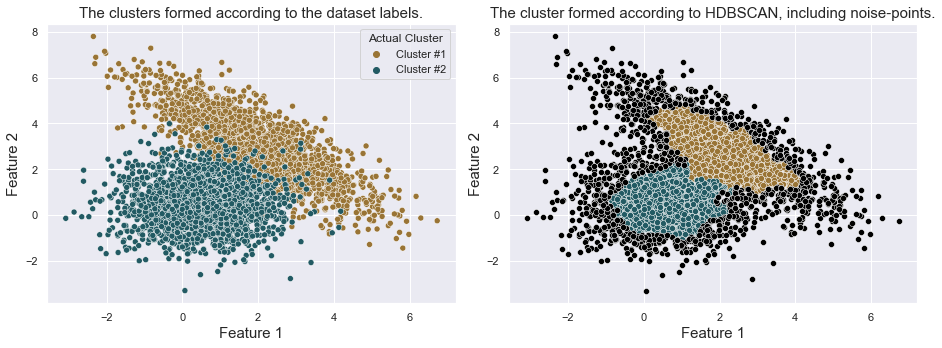

In [24]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(13,5))

sns.scatterplot(ax=ax1, x='Feature 1', y='Feature 2', data=df, hue='Actual Cluster', palette=palette, alpha=1.0)
ax1.set_title("The clusters formed according to the dataset labels.", fontsize=15)
ax1.set_xlabel("Feature 1", fontsize=15)
ax1.set_ylabel("Feature 2", fontsize=15)

# Black removed and is used for noise instead.
for k in set(preds_hdb):
    if k == -1:
        # Black used for noise.
        col = 'Black'
    elif k == 0:
        col = mycomplcol
    else:
        col = mycol

    class_member_mask = preds_hdb == k

    xy = X_small[class_member_mask]
    ax2.plot(xy[:, 0], xy[:, 1], "o", mfc=col, markeredgecolor="white", markersize=6, mew=0.5, alpha=1.0)

ax2.set_title("The cluster formed according to HDBSCAN, including noise-points.", fontsize=15)
ax2.set_xlabel("Feature 1", fontsize=15)
ax2.set_ylabel("Feature 2", fontsize=15)

plt.tight_layout()
plt.show()

Πράγματι, ο HDBSCAN καταφέρνει (τεχνηέντως) να περιοριστεί σε ακριβώς δύο συστάδες, αλλά δυστυχώς αναγνωρίζει πάρα πολλά σημεία ως θόρυβο. Ποσοτικά, η συσταδοποίηση του HDBSCAN συνοψίζεται ως:

In [25]:
print(f"The number of clusters calculated by HDBSCAN is {len(np.unique(preds_hdb))-1}.")
for i,x in enumerate(np.unique(preds_hdb)):
    num = (preds_hdb==x).sum()
    if x == -1:
        print(f"The number of calculated noise-points are {num}.")
    else:
        print(f"The number of points assigned into Cluster No. {i} is {num}.")

The number of clusters calculated by HDBSCAN is 2.
The number of calculated noise-points are 1306.
The number of points assigned into Cluster No. 1 is 1393.
The number of points assigned into Cluster No. 2 is 1397.


Σε ό,τι αφορά τις σχετικές μετρικές, παίρνουμε:

In [26]:
adj_rand = CustRound(metrics.adjusted_rand_score(y_small, preds_hdb))
adj_mut = CustRound(metrics.adjusted_mutual_info_score(y_small, preds_hdb))
v = CustRound(metrics.v_measure_score(y_small, preds_hdb))

print(f"The Adjusted Rand Index score for HDBSCAN is {adj_rand}%.")
print(f"The Adjusted Mutual Information score for HDBSCAN is {adj_mut}%.")
print(f"The V-Measure score for HDBSCAN is {v}%.")

adj_rand_inds.append(adj_rand)
adj_mut_info.append(adj_mut)
v_meas.append(v)

The Adjusted Rand Index score for HDBSCAN is 39.85%.
The Adjusted Mutual Information score for HDBSCAN is 41.12%.
The V-Measure score for HDBSCAN is 41.13%.


Φυσικά, τα αποτελέσματα αυτά είναι πολύ καλύτερα από τα αντίστοιχα του DBSCAN, αλλά σε καμία περίπτωση δε μπορούν να θεωρηθούν ικανοποιητικά. Ο ανανεωμένος πίνακας φαίνεται παρακάτω, με το GMM Clustering να παραμένει ο βέλτιστος αλγόριθμος συσταδοποίησης για το συγκεκριμένο πρόβλημα.

| | k-Means | HAC - Single | HAC - Average | HAC - Complete | HAC - Ward | GMM | DBSCAN | HDBSCAN |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| **Adjusted Rand Index** | 81.51% | 0.00% | 5.10% | 4.06% | 71.85% | <font color='green'>87.16%</font> | 0.00% | 39.85% |
| **Adjusted Mutual Information** | 72.96% | 0.05% | 14.85% | 13.92% | 64.69% | <font color='green'>79.02%</font> | 0.01% | 41.12% |
| **V-Measure** | 72.96% | 0.10% | 14.87% | 13.94% | 64.70% | <font color='green'>79.03%</font> | 0.02% | 41.13% |

### Αλγόριθμος SOM

Ο τελευταίος αλγόριθμος που θα μελετήσουμε στα πλαίσια της παρούσας εργασίας είναι ο SOM, σε υλοποίηση `sklearn-som`. Μέσω των παραμέτρων `m` και `n`, δηλαδή τις διαστάσεις του SOM, μπορούμε να ελέγξουμε το πλήθος των συστάδων που θέλουμε να αναγνωριστούν από τον αλγόριθμο. Ως προς την παράμετρο `dim`, αυτή ισούται απλώς με τον αριθμό των χαρακτηριστικών που έχει το παρόν σύνολο δεδομένων.

In [27]:
# import the library
from sklearn_som.som import SOM

clusterer = SOM(m=2, n=1, dim=2, random_state=24)
preds_som = clusterer.fit_predict(X_small) # To have same labels

In [28]:
# Update the dataframe
df = df.copy()
df['SOM Binary'] = preds_som
df.loc[(df['SOM Binary']==0), 'SOM Cluster'] = 'Cluster #1'
df['SOM Cluster'] = df['SOM Cluster'].fillna('Cluster #2')

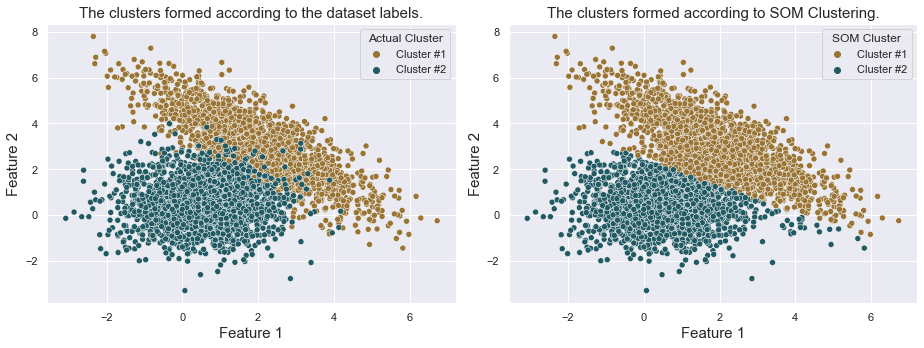

In [29]:
# Plot the two clusters
ClustCompare(df,'Actual Cluster','SOM Cluster','SOM Clustering')

Όπως ήταν μάλλον αναμενόμενο, η απόδοση του SOM μοιάζει αρκετά με αυτή του k-Means. Σε ό,τι αφορά τις μετρικές, ισχύουν:

In [30]:
adj_rand = CustRound(metrics.adjusted_rand_score(y_small, preds_som))
adj_mut = CustRound(metrics.adjusted_mutual_info_score(y_small, preds_som))
v = CustRound(metrics.v_measure_score(y_small, preds_som))

print(f"The Adjusted Rand Index score for the SOM Clustering is {adj_rand}%.")
print(f"The Adjusted Mutual Information score for the SOM Clustering is {adj_mut}%.")
print(f"The V-Measure score for the SOM Clustering is {v}%.")

adj_rand_inds.append(adj_rand)
adj_mut_info.append(adj_mut)
v_meas.append(v)

The Adjusted Rand Index score for the SOM Clustering is 82.57%.
The Adjusted Mutual Information score for the SOM Clustering is 73.92%.
The V-Measure score for the SOM Clustering is 73.93%.


Πράγματι, η επίδοση φαίνεται να είναι πολύ κοντά σε αυτήν του k-Means και βάσει των αποτελεσμάτων για τις μετρικές. Η τελική μορφή του πίνακα των αποτελεσμάτων είναι η ακόλουθη:

| | k-Means | HAC - Single | HAC - Average | HAC - Complete | HAC - Ward | GMM | DBSCAN | HDBSCAN | SOM |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| **Adjusted Rand Index** | 81.51% | 0.00% | 5.10% | 4.06% | 71.85% | <font color='green'>87.16%</font> | 0.00% | 39.85% | 82.57% |
| **Adjusted Mutual Information** | 72.96% | 0.05% | 14.85% | 13.92% | 64.69% | <font color='green'>79.02%</font> | 0.01% | 41.12% | 73.92% |
| **V-Measure** | 72.96% | 0.10% | 14.87% | 13.94% | 64.70% | <font color='green'>79.03%</font> | 0.02% | 41.13% | 73.93% |

### Συμπεράσματα

Όπως αναμέναμε εξ αρχής, αδιαμφισβήτητα η καλύτερη επιλογή για τη συσταδοποίηση του συγκεκριμένου συνόλου ως προς όλες τις μετρικές είναι η συσταδοποίηση μέσω μίγματος δύο Γκαουσιανών. Μάλιστα, εάν κανείς επισκεφθεί την [ιστοσελίδα](https://www.uni-marburg.de/fb12/arbeitsgruppen/datenbionik/data) της fcps όπου βρίσκεται το συγκεκριμένο σύνολο δεδομένων, εύκολα μπορεί να επιβεβαιώσει πως αυτό αντιστοιχεί πράγματι σε μίγμα δύο Γκαουσιανών.

Κλείνοντας τη μελέτη του συνόλου αυτού και πριν προχωρήσουμε στο 128-διάστατο σύνολο, παραθέτουμε τους πίνακες σύγχυσης του GMM (δεξιά) και του HAC - Single (αριστερά), δηλαδή του καλύτερου και του χειρότερου αλγόριθμου, αντίστοιχα. Ο λόγος για τον οποίο η σύγκριση δεν γίνεται με τον DBSCAN είναι πως τότε δε θα είχαμε μια σύγκριση «επί ίσοις όροις», αφού στον HAC - Single δώσαμε την οδηγία να αναζητήσει 2 συστάδες, κάτι το οποίο δεν είχαμε τη δυνατότητα να κάνουμε για τον DBSCAN, λόγω κατασκευής του.

In [31]:
# Custom colormap
def CustomCmap(from_rgb,to_rgb):

    # from color r,g,b
    r1,g1,b1 = from_rgb

    # to color r,g,b
    r2,g2,b2 = to_rgb

    cdict = {'red': ((0, r1, r1),
                   (1, r2, r2)),
           'green': ((0, g1, g1),
                    (1, g2, g2)),
           'blue': ((0, b1, b1),
                   (1, b2, b2))}

    cmap = colors.LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

mycmap = CustomCmap([1.00, 1.00, 1.00], [0.13333, 0.35294, 0.38824]) # from white to teal

from sklearn.metrics import confusion_matrix
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
    
matplotlib.rc_file_defaults() # to remove the sns darkgrid style

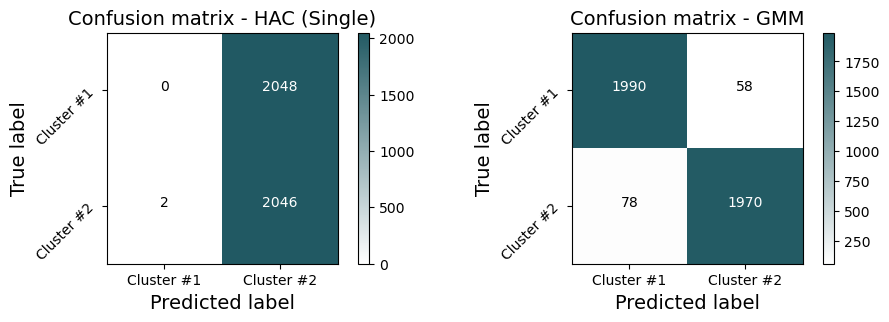

In [32]:
classes = ['Cluster #1','Cluster #2']

cfmatrix_hac = confusion_matrix(y_small, preds_single)
cfmatrix_gmm = confusion_matrix(y_small, preds_gmm)

fig, [ax1,ax2] = plt.subplots(1,2, figsize=(11,3))

for ax,cm,title in zip([ax1,ax2],[cfmatrix_hac,cfmatrix_gmm],['HAC (Single)','GMM']):
    im = ax.imshow(cm, interpolation='nearest', cmap=mycmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=.2)
    plt.colorbar(im, cax=cax) #, ticks=[-1,-0.5,0,0.5,1]
    ax.set_title(f'Confusion matrix - {title}',fontsize=14)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=45)
    
    fmt = 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label',fontsize=14)
    ax.set_xlabel('Predicted label',fontsize=14)
    
plt.show()

Όπως εξηγήθηκε και στα παραπάνω, η αποτυχία του HAC - Single βασίζεται στο γεγονός πως, παρότι θεωρητικά εντοπίζει δύο συστάδες, στην πράξη η μία από αυτές είναι τόσο μικρή που δε μπορεί να θεωρηθεί ως τέτοια. Από την άλλη, ακόμα και με όρους ορθότητας, όπως θα είχαμε σε ένα πρόβλημα ταξινόμησης, ο GMM Clusterer εμφανίζει εντυπωσιακά αποτελέσματα.

## 128D Σύνολο Δεδομένων (g2mg_128_70)

Προχωρώντας στη μελέτη του συνόλου δεδομένων που αποτελούνται από 128 χαρακτηριστικά και σε αντιστοιχία με όσα κάναμε για το προηγούμενο σύνολο δεδομένων, θα περάσουμε τα δεδομένα σε ένα pandas dataframe. Κρίνουμε σκόπιμο να πραγματοποιήσουμε εξ αρχής μια κανονικοποίηση των δεδομένων μας.

In [33]:
# Standardization
X_big = StandardScaler().fit_transform(X_big)

# Casting the numpy array into a pandas dataframe for easier manipulations
df = pd.DataFrame(X_big)

# Setting some basic header names
column_dict = {}
for i in range(X_big.shape[1]):
    column_dict[i] = 'Feature '+str(i+1)

df = df.rename(columns=column_dict)
df['Actual Cluster Binary'] = y_big
df.loc[(df['Actual Cluster Binary']==0), 'Actual Cluster'] = 'Cluster #1'
df['Actual Cluster'] = df['Actual Cluster'].fillna('Cluster #2')

Δυστυχώς, η οπτικοποίηση των δεδομένων παύει πλέον να αποτελεί ένα εργαλείο που μπορούμε να αξιοποιήσουμε για να εξαγάγουμε πληροφορία οπτικά και ως εκ τούτου όλη μας η πληροφορία για την επιτυχία ή την αποτυχία του εκάστοτε αλγορίθμου θα προέρχεται από τα αποτελέσματα των μετρικών.

Με βάση αυτά, προχωρούμε στην εφαρμογή των προηγούμενων αλγορίθμων με τη σειρά, προκειμένου να δούμε ποιος θα κριθεί καταλληλότερος για τη συσταδοποίηση των δεδομένων αυτού του συνόλου. Σημειώνουμε πως, μιας και τώρα τα δεδομένα έχουν πολύ περισσότερα χαρακτηριστικά απ' ότι πριν, ο συνολικός χρόνος που απαιτεί κάθε αλγόριθμος για τη συσταδοποίηση θα αποτελέσει ένα σημαντικό κριτήριο σχετικά με την τελική μας επιλογή, επομένως θα καταγράφεται.

### Αλγόριθμος k-Means

Επαναλαμβάνοντας ακριβώς τα προηγούμενα βήματα, πλην αυτό της οπτικοποίησης, παίρνουμε τα ακόλουθα διαγνωστικά.

In [34]:
start_t = time.time()
bpreds_kmeans = KMeans(n_clusters=2, random_state=24).fit_predict(X_big)
end_t = time.time()

# Initialize new lists to store the scores
badj_rand_inds = []
badj_mut_info = []
bv_meas = []
times = []

adj_rand = CustRound(metrics.adjusted_rand_score(y_big, bpreds_kmeans))
adj_mut = CustRound(metrics.adjusted_mutual_info_score(y_big, bpreds_kmeans))
v = CustRound(metrics.v_measure_score(y_big, bpreds_kmeans))
t = round(end_t-start_t,2)

print(f"The Adjusted Rand Index score for the k-Means clustering is {adj_rand}%.")
print(f"The Adjusted Mutual Information score for the k-Means clustering is {adj_mut}%.")
print(f"The V-Measure score for the k-Means clustering is {v}%.")
print(f"Total time elapsed for the clustering process: {t} s.")

badj_rand_inds.append(adj_rand)
badj_mut_info.append(adj_mut)
bv_meas.append(v)
times.append(t)

The Adjusted Rand Index score for the k-Means clustering is 40.89%.
The Adjusted Mutual Information score for the k-Means clustering is 32.01%.
The V-Measure score for the k-Means clustering is 32.03%.
Total time elapsed for the clustering process: 0.08 s.


Στην περίπτωση αυτή, τα αποτελέσματα της συσταδοποίησης μέσω k-Means δεν είναι τόσο ικανοποιητικά όσο πριν. Σε κάθε περίπτωση είναι θετικό πως η σύγκλιση του αλγορίθμου επέρχεται αρκετά σύντομα. Παραθέτουμε παρακάτω ένα νέο πίνακα markdown για να αποθηκεύουμε τις επιδόσεις κάθε αλγορίθμου, συμπεριλαμβανομένου αυτή τη φορά και του χρόνου εκτέλεσης.

| | k-Means |
| :-: | :-: |
| **Adjusted Rand Index** | <font color='green'>40.89%</font> |
| **Adjusted Mutual Information** | <font color='green'>32.01%</font> |
| **V-Measure** | <font color='green'>32.03%</font> |
| **Time** | 0.08 s |

### Αλγόριθμος HAC

Εφαρμόζοντας ξανά την υλοποίηση της `fastcluster` για τον HAC με συνδέσμους Single, Average, Complete και Ward προκύπτει:

In [35]:
start_t = time.time()
# Compute linkage matrix
Z1 = fastcluster.single(X_big)
# Find the cluster labels
bpreds_single = fcluster(Z1, 2, criterion='maxclust')
end_t = time.time()
t = round(end_t-start_t,2)
times.append(t)

start_t = time.time()
# Compute linkage matrix
Z2 = fastcluster.average(X_big)
# Find the cluster labels
bpreds_avg = fcluster(Z2, 2, criterion='maxclust')
end_t = time.time()
t = round(end_t-start_t,2)
times.append(t)

start_t = time.time()
# Compute linkage matrix
Z3 = fastcluster.complete(X_big)
# Find the cluster labels
bpreds_cmpl = fcluster(Z3, 2, criterion='maxclust')
end_t = time.time()
t = round(end_t-start_t,2)
times.append(t)

start_t = time.time()
# Compute linkage matrix
Z4 = fastcluster.ward(X_big)
# Find the cluster labels
bpreds_ward = fcluster(Z4, 2, criterion='maxclust')
end_t = time.time()
t = round(end_t-start_t,2)
times.append(t)

for idx, hacpreds, hactype in zip([1,2,3,4],[bpreds_single,bpreds_avg,bpreds_cmpl,bpreds_ward],
                                  ['Single','Average','Complete','Ward']):

    adj_rand = CustRound(metrics.adjusted_rand_score(y_big, hacpreds))
    adj_mut = CustRound(metrics.adjusted_mutual_info_score(y_big, hacpreds))
    v = CustRound(metrics.v_measure_score(y_big, hacpreds))

    print(f"The Adjusted Rand Index score for the HAC {hactype} is {adj_rand}%.")
    print(f"The Adjusted Mutual Information score for the HAC {hactype} is {adj_mut}%.")
    print(f"The V-Measure score for the HAC {hactype} is {v}%.")
    print(f"Total time elapsed for the clustering process: {times[idx]} s.")
    print(101*'-')

    badj_rand_inds.append(adj_rand)
    badj_mut_info.append(adj_mut)
    bv_meas.append(v)

The Adjusted Rand Index score for the HAC Single is 0.0%.
The Adjusted Mutual Information score for the HAC Single is 0.0%.
The V-Measure score for the HAC Single is 0.1%.
Total time elapsed for the clustering process: 0.22 s.
-----------------------------------------------------------------------------------------------------
The Adjusted Rand Index score for the HAC Average is 0.0%.
The Adjusted Mutual Information score for the HAC Average is 0.0%.
The V-Measure score for the HAC Average is 0.1%.
Total time elapsed for the clustering process: 0.23 s.
-----------------------------------------------------------------------------------------------------
The Adjusted Rand Index score for the HAC Complete is 1.07%.
The Adjusted Mutual Information score for the HAC Complete is 0.8%.
The V-Measure score for the HAC Complete is 0.83%.
Total time elapsed for the clustering process: 0.23 s.
-----------------------------------------------------------------------------------------------------
Th

Οι αλγόριθμοι τύπου HAC φαίνεται να χρειάζονται περισσότερο χρόνο από τον k-Means για να πραγματοποιήσουν τη συσταδοποίηση και τα αποτελέσματά τους είναι εξαιρετικά απογοητευτικά. Ακόμη και ο HAC με σύνδεσμο Ward, που στο προηγούμενο σύνολο δεδομένων είχε απόδοση συγκρίσιμη με του k-Means, τώρα εμφανίζει σκορ κάτω του 10% για κάθε μετρική.

| | k-Means | HAC - Single | HAC - Average | HAC - Complete | HAC - Ward |
| :-: | :-: | :-: | :-: | :-: | :-: |
| **Adjusted Rand Index** | <font color='green'>40.89%</font> | 0.00% | 0.00% | 1.07% | 5.41% |
| **Adjusted Mutual Information** | <font color='green'>32.01%</font> | 0.00% | 0.00% | 0.80% | 5.98% |
| **V-Measure** | <font color='green'>32.03%</font> | 0.10% | 0.10% | 0.83% | 6.02% |
| **Time** | 0.08 s | 0.22 s | 0.23 s | 0.23 s | 0.22 s |

### Αλγόριθμος GMM

Η συσταδοποίηση μέσω GMM ήταν αυτή που στο προηγούμενο σύνολο δεδομένων έδωσε τα βέλτιστα αποτελέσματα. Ας δούμε την επίδοσή της εδώ:

In [36]:
start_t = time.time()
# setup the model
gmm = GaussianMixture(n_components=2, random_state=24)
# predict labels
bpreds_gmm = gmm.fit_predict(X_big)
end_t = time.time()
t = round(end_t-start_t,2)

adj_rand = CustRound(metrics.adjusted_rand_score(y_big, bpreds_gmm))
adj_mut = CustRound(metrics.adjusted_mutual_info_score(y_big, bpreds_gmm))
v = CustRound(metrics.v_measure_score(y_big, bpreds_gmm))

print(f"The Adjusted Rand Index score for GMM Clustering is {adj_rand}%.")
print(f"The Adjusted Mutual Information score for GMM Clustering is {adj_mut}%.")
print(f"The V-Measure score for GMM Clustering is {v}%.")
print(f"Total time elapsed for the clustering process: {t} s.")

badj_rand_inds.append(adj_rand)
badj_mut_info.append(adj_mut)
bv_meas.append(v)
times.append(t)

The Adjusted Rand Index score for GMM Clustering is 36.75%.
The Adjusted Mutual Information score for GMM Clustering is 28.52%.
The V-Measure score for GMM Clustering is 28.54%.
Total time elapsed for the clustering process: 0.11 s.


Δυστυχώς, στην περίπτωση αυτή ο GMM δεν έχει απόδοση ισάξια της προηγούμενης, αν και ξεπερνά κατά πολύ τις επιδόσεις των HAC και πλησιάζει, χωρίς να ξεπερνά, τον k-Means. Ο ανανεωμένος πίνακας φαίνεται παρακάτω.

| | k-Means | HAC - Single | HAC - Average | HAC - Complete | HAC - Ward | GMM |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| **Adjusted Rand Index** | <font color='green'>40.89%</font> | 0.00% | 0.00% | 1.07% | 5.41% | 36.75% |
| **Adjusted Mutual Information** | <font color='green'>32.01%</font> | 0.00% | 0.00% | 0.80% | 5.98% | 28.52% |
| **V-Measure** | <font color='green'>32.03%</font> | 0.10% | 0.10% | 0.83% | 6.02% | 28.54% |
| **Time** | 0.08 s | 0.22 s | 0.23 s | 0.23 s | 0.22 s | 0.11 s |

### Αλγόριθμος DBSCAN

Περνάμε ξανά στον DBSCAN, ο οποίος στην προηγούμενη περίπτωση δε μπορούσε να διαχωρίσει περισσότερες από 1 συστάδες, λόγω της πρακτικά ομοιόμορφης πυκνότητας των σημείων.

In [37]:
start_t = time.time()
# perform dbscan using default values
bpreds_db = DBSCAN(eps=12.8, min_samples=3, n_jobs=-1).fit_predict(X_big)
end_t = time.time()
t = round(end_t-start_t,2)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(bpreds_db)) - (1 if -1 in bpreds_db else 0)
n_noise_ = list(bpreds_db).count(-1)

print(f"The number of cluster(s) identified is {n_clusters_}, while {n_noise_} points have been treated as noise.")

The number of cluster(s) identified is 2, while 1430 points have been treated as noise.


Επειδή με τις default τιμές των παραμέτρων της η DBSCAN αποτυγχάνει να βρει οποιοδήποτε cluster, στην παραπάνω κλήση της έχουν δοθεί διαφορετικές τιμές στις παραμέτρους αυτές. Μάλιστα, ρυθμίζοντας λιγάκι τις παραμέτρους «με το χέρι», καταφέρνουμε να πάρουμε μια ρύθμιση για την οποία η DBSCAN αναγνωρίζει 2 συστάδες. Ας δούμε τα διαγνωστικά:

In [38]:
adj_rand = CustRound(metrics.adjusted_rand_score(y_big, bpreds_db))
adj_mut = CustRound(metrics.adjusted_mutual_info_score(y_big, bpreds_db))
v = CustRound(metrics.v_measure_score(y_big, bpreds_db))

print(f"The Adjusted Rand Index score for DBSCAN is {adj_rand}%.")
print(f"The Adjusted Mutual Information score for DBSCAN is {adj_mut}%.")
print(f"The V-Measure score for DBSCAN is {v}%.")
print(f"Total time elapsed for the clustering process: {t} s.")

badj_rand_inds.append(adj_rand)
badj_mut_info.append(adj_mut)
bv_meas.append(v)
times.append(t)

The Adjusted Rand Index score for DBSCAN is -0.01%.
The Adjusted Mutual Information score for DBSCAN is -0.05%.
The V-Measure score for DBSCAN is 0.04%.
Total time elapsed for the clustering process: 0.07 s.


Δυστυχώς, η DBSCAN αποτυγχάνει και πάλι να εντοπίσει τις σωστές συστάδες, αν και ο χρόνος εκτέλεσής της είναι όμοιος αυτού της k-Means.

| | k-Means | HAC - Single | HAC - Average | HAC - Complete | HAC - Ward | GMM | DBSCAN |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| **Adjusted Rand Index** | <font color='green'>40.89%</font> | 0.00% | 0.00% | 1.07% | 5.41% | 36.75% | -0.01% |
| **Adjusted Mutual Information** | <font color='green'>32.01%</font> | 0.00% | 0.00% | 0.80% | 5.98% | 28.52% | -0.05% |
| **V-Measure** | <font color='green'>32.03%</font> | 0.10% | 0.10% | 0.83% | 6.02% | 28.54% | 0.04% |
| **Time** | 0.08 s | 0.22 s | 0.23 s | 0.23 s | 0.22 s | 0.11 s | 0.07 s |

### Αλγόριθμος HDBSCAN

Εφόσον η DBSCAN απέτυχε ξανά να πραγματοποιήσει σωστά τη συσταδοποίηση, και σε αυτήν την περίπτωση θα χρησιμοποιήσουμε τη μέθοδο `flat`, ώστε να «αναγκάσουμε» την HDBSCAN να αναγνωρίσει 2 συστάδες, ελπίζοντας για κάπως καλύτερα αποτελέσματα.

In [39]:
start_t = time.time()
clusterer = HDBSCAN_flat(X_big, cluster_selection_method='eom', n_clusters=2)
# predictions
bpreds_hdb = clusterer.labels_
end_t = time.time()
t = round(end_t-start_t,2)

print(f"The number of clusters calculated by HDBSCAN is {len(np.unique(bpreds_hdb))-1}.")
for i,x in enumerate(np.unique(bpreds_hdb)):
    num = (bpreds_hdb==x).sum()
    if x == -1:
        print(f"The number of calculated noise-points are {num}.")
    else:
        print(f"The number of points assigned into Cluster No. {i} is {num}.")

The number of clusters calculated by HDBSCAN is 2.
The number of calculated noise-points are 2019.
The number of points assigned into Cluster No. 1 is 6.
The number of points assigned into Cluster No. 2 is 23.


Δυστυχώς, ούτε η HDBSCAN έχει την επιθυμητή διακριτική ικανότητα, όπως μπορούμε να καταλάβουμε από το πλήθος των ταξινομήσεων που πραγματοποιεί, πριν καν δούμε τις σχετικές μετρικές.

In [40]:
adj_rand = CustRound(metrics.adjusted_rand_score(y_big, bpreds_hdb))
adj_mut = CustRound(metrics.adjusted_mutual_info_score(y_big, bpreds_hdb))
v = CustRound(metrics.v_measure_score(y_big, bpreds_hdb))

print(f"The Adjusted Rand Index score for HDBSCAN is {adj_rand}%.")
print(f"The Adjusted Mutual Information score for HDBSCAN is {adj_mut}%.")
print(f"The V-Measure score for HDBSCAN is {v}%.")
print(f"Total time elapsed for the clustering process: {t} s.")

badj_rand_inds.append(adj_rand)
badj_mut_info.append(adj_mut)
bv_meas.append(v)
times.append(t)

The Adjusted Rand Index score for HDBSCAN is -0.0%.
The Adjusted Mutual Information score for HDBSCAN is -0.07%.
The V-Measure score for HDBSCAN is 0.07%.
Total time elapsed for the clustering process: 1.34 s.


Ο ανανεωμένος πίνακας markdown φαίνεται παρακάτω.

| | k-Means | HAC - Single | HAC - Average | HAC - Complete | HAC - Ward | GMM | DBSCAN | HDBSCAN |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| **Adjusted Rand Index** | <font color='green'>40.89%</font> | 0.00% | 0.00% | 1.07% | 5.41% | 36.75% | -0.01% | 0.00% |
| **Adjusted Mutual Information** | <font color='green'>32.01%</font> | 0.00% | 0.00% | 0.80% | 5.98% | 28.52% | -0.05% | -0.07% |
| **V-Measure** | <font color='green'>32.03%</font> | 0.10% | 0.10% | 0.83% | 6.02% | 28.54% | 0.04% | 0.07% |
| **Time** | 0.08 s | 0.22 s | 0.23 s | 0.23 s | 0.22 s | 0.11 s | 0.07 s | 1.34 s |

### Αλγόριθμος SOM

Κλείνουμε την παρούσα ανάλυση παραθέτοντας τα αποτελέσματα του αλγορίθμου SOM.

In [41]:
start_t = time.time()
clusterer = SOM(m=2, n=1, dim=X_big.shape[1], random_state=24)
bpreds_som = clusterer.fit_predict(X_big)
end_t = time.time()
t = round(end_t-start_t,2)

adj_rand = CustRound(metrics.adjusted_rand_score(y_big, bpreds_som))
adj_mut = CustRound(metrics.adjusted_mutual_info_score(y_big, bpreds_som))
v = CustRound(metrics.v_measure_score(y_big, bpreds_som))

print(f"The Adjusted Rand Index score for SOM Clustering is {adj_rand}%.")
print(f"The Adjusted Mutual Information score for SOM Clustering is {adj_mut}%.")
print(f"The V-Measure score for SOM Clustering is {v}%.")
print(f"Total time elapsed for the clustering process: {t} s.")

badj_rand_inds.append(adj_rand)
badj_mut_info.append(adj_mut)
bv_meas.append(v)
times.append(t)

The Adjusted Rand Index score for SOM Clustering is 1.19%.
The Adjusted Mutual Information score for SOM Clustering is 0.86%.
The V-Measure score for SOM Clustering is 0.9%.
Total time elapsed for the clustering process: 0.38 s.


Και ο SOM, σε αντίθεση με την προηγούμενη περίπτωση, παρουσιάζει μη ικανοποιητική επίδοση, χειρότερη και από αυτήν της HAC - Ward. Παραθέτουμε παρακάτω την τελική μορφή του Πίνακα των επιδόσεων.

| | k-Means | HAC - Single | HAC - Average | HAC - Complete | HAC - Ward | GMM | DBSCAN | HDBSCAN | SOM |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| **Adjusted Rand Index** | <font color='green'>40.89%</font> | 0.00% | 0.00% | 1.07% | 5.41% | 36.75% | -0.01% | 0.00% | 1.19% |
| **Adjusted Mutual Information** | <font color='green'>32.01%</font> | 0.00% | 0.00% | 0.80% | 5.98% | 28.52% | -0.05% | -0.07% | 0.86% |
| **V-Measure** | <font color='green'>32.03%</font> | 0.10% | 0.10% | 0.83% | 6.02% | 28.54% | 0.04% | 0.07% | 0.90% |
| **Time** | 0.08 s | 0.22 s | 0.23 s | 0.23 s | 0.22 s | 0.11 s | 0.07 s | 1.34 s | 0.38 s |

### Συμπεράσματα

Κλείνοντας τη μελέτη του 128-διάστατου συνόλου δεδομένων και κατ' επέκταση του δεύτερου αυτού μέρους της εργασίας, συμπεραίνουμε πως η συσταδοποίηση πολυδιάστατων δεδομένων είναι μια καθόλου τετριμμένη διαδικασία, η οποία, ακόμη κι αν γνωρίζουμε το πραγματικό πλήθος συστάδων, δεν εγγυάται να δώσει καλά αποτελέσματα. Στην περίπτωσή μας, τη βέλτιστη επίδοση έχει ο αλγόριθμος k-Means, με Adjusted Rand Index μόλις ~41% και Adjusted Mutual Information/V-Measure ~ 32%. Τουλάχιστον, είναι θετικό πως ο k-Means συνδυάζει βέλτιστη επίδοση μαζί με ελάχιστο χρόνο εκτέλεσης, μόλις στα 0.08 s.

Θεωρώντας ξανά ως χειρότερη την επίδοση του HAC - Single για λόγους όμοιους με πριν (είναι αλγόριθμος φτιαγμένος για να δέχεται ως όρισμα το πλήθος των clusters, σε αντίθεση με τους DBSCAN, HDBSCAN), παραθέτουμε παρακάτω τους πίνακες σύγχυσης του HAC - Single (αριστερά) και του k-Means (δεξιά).

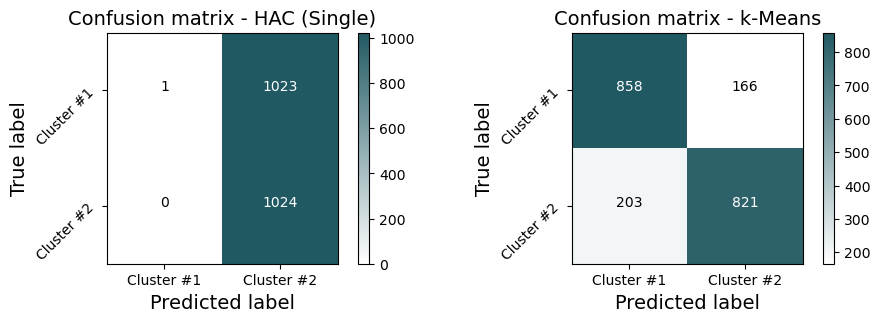

In [42]:
cfmatrix_hac = confusion_matrix(y_big, bpreds_single%2) # To fix labeling
cfmatrix_kmeans = confusion_matrix(y_big, bpreds_kmeans)

fig, [ax1,ax2] = plt.subplots(1,2, figsize=(11,3))

for ax,cm,title in zip([ax1,ax2],[cfmatrix_hac,cfmatrix_kmeans],['HAC (Single)','k-Means']):
    im = ax.imshow(cm, interpolation='nearest', cmap=mycmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=.2)
    plt.colorbar(im, cax=cax)
    ax.set_title(f'Confusion matrix - {title}',fontsize=14)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=45)
    
    fmt = 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label',fontsize=14)
    ax.set_xlabel('Predicted label',fontsize=14)
    
plt.show()

Η επίδοση του k-Means μοιάζει ικανοποιητική (δεδομένων όλων των συνθηκών) και βάσει του πίνακα σύγχυσης. Από την άλλη, ο HAC - Single, όπως και στην προηγούμενη περίπτωση, στην πράξη αναγνωρίζει μόνο 1 συστάδα, αφού στη 2η αναθέτει μόλις 1 σημείο.